In [1]:
import sys

sys.path.append('/home/caihuaiguang/DSG/pytorch-shapley-cam')

# 验证路径是否已添加
print(sys.path)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  

import torch
# 设置设备为GPU或CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

['/media/caihuaiguang/miniconda3/envs/cords/lib/python38.zip', '/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8', '/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8/lib-dynload', '', '/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8/site-packages', '/home/caihuaiguang/DSG/InfoBatch', '/home/caihuaiguang/DSG/pytorch-shapley-cam']


In [2]:
# import warnings
# warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import timm
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst
from pytorch_grad_cam.metrics.road import ROADLeastRelevantFirstAverage, ROADMostRelevantFirstAverage
from pytorch_grad_cam.metrics.road import ROADCombined
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget, ClassifierOutputLnSoftmaxTarget, ClassifierOutputExclusiveLnSoftmaxTarget, ClassifierOutputReST, ClassifierOutputReST_2
from pytorch_grad_cam.metrics.ADCC import ADCC
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM, EigenGradCAM, LayerCAM, AblationCAM, RandomCAM, ShapleyCAM, ShapleyCAM_x, ShapleyCAM_mean, ShapleyCAM_hires, GradCAMElementWise, HiResCAM, XGradCAM


In [3]:
# # selet the layer before adaptive avg pooling, i.e., norm
# def reshape_transform(result, height=7, width=7):
#     # print(result.shape)
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result

# model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
# # target_layers = [model.norm]
# target_layers = [model.layers[-1].blocks[-1].norm1]

In [4]:
# def reshape_transform(result, height=7, width=7):
#     # print(result.shape)
#     result = result.reshape(result.size(0),
#                             height, width, result.size(2))

#     # Bring the channels to the first dimension,
#     # like in CNNs.
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result

# model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
# target_layers = [model.layers[-1].blocks[-1].norm2]

In [5]:
# # vit performance is not good
# import torch
# def reshape_transform(tensor, height=14, width=14):
#     # print(tensor.shape)
#     result = tensor[:, 1:, :].reshape(tensor.size(0),
#                                       height, width, tensor.size(2))

#     # Bring the channels to the first dimension,
#     # like in CNNs.
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result
# model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

# # target_layers =  [model.blocks[-1].norm1]
# target_layers =  [model.blocks[-1].norm2]
# # target_layers =  [model.norm]

In [6]:

# model = models.resnet152(pretrained=True)
# reshape_transform = None
# # target_layers = [model.layer4[-1].conv3]
# target_layers = [model.layer4[-1].relu]

In [7]:

model = models.vgg16(pretrained=True)
reshape_transform = None
target_layers = [model.features[-1]]

/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:

# model = models.efficientnet_b0(pretrained=True)
# reshape_transform = None
# target_layers = [model.features[8][2]]

In [9]:

# model = models.resnet18(pretrained=True)
# reshape_transform = None
# # target_layers = [model.layer4[-1].conv2]
# target_layers = [model.layer4[-1].relu]

In [10]:

# model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
# reshape_transform = None
# target_layers = [model.features[-1][0]]

In [11]:
model.eval()
model = model.cuda()

# Showing the metrics on top of the CAM : 
def visualize_score(visualization, name, adcc, avg_drop, coherency, complexity, IC, ADD ):
    visualization = cv2.putText(visualization, name, (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"ADCC: {adcc:.5f}", (10, 40), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"AD: {avg_drop:.5f}", (10, 55), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    visualization = cv2.putText(visualization, f"Coherency: {coherency:.5f}", (10, 70), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    visualization = cv2.putText(visualization, f"Complexity: {complexity:.5f}", (10, 85), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    visualization = cv2.putText(visualization, f"IC: {IC:.5f}", (10, 100), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    visualization = cv2.putText(visualization, f"ADD: {ADD:.5f}", (10, 115), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    return visualization
    
def benchmark(_img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=None):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
    #            ("HiResCAM", HiResCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
    #            ("LayerCAM", LayerCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
    #            ("GradCAM-E", GradCAMElementWise(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
    #         #    ("ScoreCAM", ScoreCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
    #            ("XGradCAM", XGradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
    #            ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
    #            ("ShapleyCAM-E", ShapleyCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
    #            ("ShapleyCAM-M", ShapleyCAM_mean(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
    #            ("ShapleyCAM-H", ShapleyCAM_hires(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
    #            ("ShapleyCAM-X", ShapleyCAM_x(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
    #            ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
    #         #    ("AblationCAM", AblationCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform, ablation_layer=AblationLayerVit())),
    #            ("RandomCAM", RandomCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
               ]

    cam_metric = ADCC()
    # targets = [ClassifierOutputTarget(category)]
    # targets = [ClassifierOutputSoftmaxTarget(category)]
    # targets = [ClassifierOutputLnSoftmaxTarget(category)]
    # targets = [ClassifierOutputExclusiveLnSoftmaxTarget(category)]
    # targets = [ClassifierOutputEntropy(category)]
    targets = [ClassifierOutputReST_2(category[0]),ClassifierOutputReST_2(category[1])]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    
    visualizations = []
    for name, cam_method in methods:
        attributions = cam_method(input_tensor=input_tensor, 
                                    targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]   
        adcc, avg_drop, coherency, complexity, inc, dropindeletion   =cam_metric(input_tensor,attributions,targets,metric_targets,model, cam_method)
        visualization = show_cam_on_image(_img_example, attribution, use_rgb=True)
        visualization = visualize_score(visualization, name, adcc[0], avg_drop[0], coherency[0], complexity[0], inc[0], dropindeletion[0] )
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))


In [12]:
# import torch
# from torchvision import datasets, transforms, models
# from torch.utils.data import DataLoader
# import timm
# from tqdm import tqdm


# # 标准的ImageNet图像预处理
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # 加载ImageNet验证集
# val_dataset = datasets.ImageFolder('/media/caihuaiguang/data/ILSVRC2012_img_val', transform=transform)
# val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

# model = model.to(device)
# model.eval()

# # 初始化统计变量
# correct = 0
# total = 0

# # 迭代验证集进行预测
# with torch.no_grad():
#     for batch_idx, (imgs, labels) in enumerate(tqdm(val_loader, desc="Processing images", unit="batch")):
#         if batch_idx == 100:
#             break
#         imgs = imgs.to(device)
#         labels = labels.to(device)
        
#         # 模型推理
#         outputs = model(imgs)
#         # prob, predicted = torch.max(outputs.data, 1)
#         probabilities = torch.nn.functional.softmax(outputs, dim=1)
#         prob, predicted = torch.max(probabilities, 1)

#         # 统计准确数量
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
        
#         # 查找错误预测的文件名
#         batch_start_idx = batch_idx * val_loader.batch_size  # 当前批次在数据集中起始的索引
#         for i in range(len(predicted)):
#             # if predicted[i] != labels[i]:  # 预测错误时
#             #     # 获取当前样本的文件路径
#             #     file_path = val_dataset.samples[batch_start_idx + i][0]
#             #     print(f"Misclassified: {file_path}, Predicted: {predicted[i].item()}, Actual: {labels[i].item()}")
#             epsilon = 1e-15  # 可以根据需要调整
#             if abs(prob[i] - 1) < epsilon:
#                 file_path = val_dataset.samples[batch_start_idx + i][0]
#                 print(f"wow!: {file_path}, Predicted: {predicted[i].item()}, Actual: {labels[i].item()},  Prob: {prob[i]:.8f}")

# # 计算并打印准确率
# accuracy = 100 * correct / total
# print(f'Accuracy on the ImageNet validation set: {accuracy:.2f}%')


In [13]:
# https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
# using this link to get label name from ID (start from 0) 

In [14]:
## mul
# img_example = np.array(Image.open("./ILSVRC2012_val_00023935.JPEG")) 
# img_example = np.array(Image.open("./ILSVRC2012_val_00007197.JPEG")) 
# img_example = np.array(Image.open("./ILSVRC2012_val_00006149.JPEG")) 
img_example = np.array(Image.open("./ILSVRC2012_val_00022113.JPEG")) 
# img_example = np.array(Image.open("../examples/both.png")) 


img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model.cuda()
input_tensor = input_tensor.cuda()

model.eval()
outputs = model(input_tensor)
_, predicted = torch.max(outputs.data, 1)
_, predicted_min = torch.min(outputs.data, 1)
print(predicted) # 2: great white shark
print(predicted_min) # 90: lorikeet

np.random.seed(42)

tensor([29], device='cuda:0')
tensor([839], device='cuda:0')


In [15]:
outputs = torch.softmax(outputs,dim=1)

In [16]:

# 获取前5个最高概率的标签及其对应的索引
top5_probs, top5_indices = torch.topk(outputs, 5, dim=1)

# 获取前5个最低概率的标签及其对应的索引
bottom5_probs, bottom5_indices = torch.topk(outputs, 5, dim=1, largest=False)

# 打印前5个最高概率的标签和对应概率
print("Top 5 labels and probabilities for each example:")
for i in range(outputs.size(0)): 
    for j in range(5):
        print(f"Label: {top5_indices[i][j].item()}, Probability: {top5_probs[i][j].item()}")

# 打印前5个最低概率的标签和对应概率
print("\nLowest 5 labels and probabilities for each example:")
for i in range(outputs.size(0)): 
    for j in range(5):
        print(f"Label: {bottom5_indices[i][j].item()}, Probability: {bottom5_probs[i][j].item()}")

Top 5 labels and probabilities for each example:
Label: 29, Probability: 1.0
Label: 26, Probability: 2.3089956596028527e-12
Label: 1, Probability: 1.534872489522554e-12
Label: 115, Probability: 1.9635092434345386e-13
Label: 390, Probability: 5.2465081839528013e-14

Lowest 5 labels and probabilities for each example:
Label: 839, Probability: 1.2954662807738773e-27
Label: 863, Probability: 3.573037618121687e-27
Label: 682, Probability: 5.3187359568252546e-27
Label: 537, Probability: 6.813752942851446e-27
Label: 873, Probability: 9.958261133511263e-27


In [17]:

category = top5_indices[0][0] #  label is 3 (tiger shark), but resnet18 think it is 2 (great white shark)
device = outputs.device  # Make sure this matches the device where you are working
# Create the batch of tensors correctly
input_batch = torch.stack([input_tensor[0], input_tensor[0]]).to(device)  # Ensure proper batching
# Create a tensor of categories for the batch
category_batch = [category, category]
print(category_batch)
# Call the benchmark function
benchmark(img_example, input_batch, target_layers, eigen_smooth=False, aug_smooth=False, category=category_batch)

[tensor(29, device='cuda:0'), tensor(29, device='cuda:0')]
model_output.shape torch.Size([1000])
torch.Size([1]) torch.Size([1, 1000])
tensor(49.4271, device='cuda:0', grad_fn=<SubBackward0>)
model_output.shape torch.Size([1000])
torch.Size([1]) torch.Size([1, 1000])
tensor(49.4271, device='cuda:0', grad_fn=<SubBackward0>)


IndexError: too many indices for tensor of dimension 1

torch.Size([1]) torch.Size([1, 1000])
tensor(-4.1607, device='cuda:0', grad_fn=<SubBackward0>)
torch.Size([1]) torch.Size([1, 1000])
tensor(2.1550, device='cuda:0', grad_fn=<SubBackward0>)


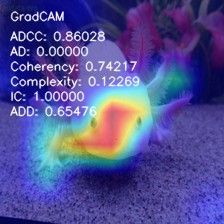

In [18]:
category = top5_indices[0][1] #  label is 3(tiger shark), but resnet18 think it is 2(great white shark)
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

torch.Size([1]) torch.Size([1, 1000])
tensor(-4.9774, device='cuda:0', grad_fn=<SubBackward0>)
torch.Size([1]) torch.Size([1, 1000])
tensor(1.4506, device='cuda:0', grad_fn=<SubBackward0>)


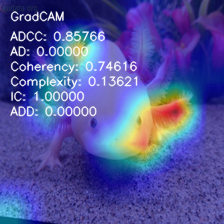

In [19]:
category = top5_indices[0][2] #  label is 3, but resnet18 think it is 2
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

torch.Size([1]) torch.Size([1, 1000])
tensor(-9.0900, device='cuda:0', grad_fn=<SubBackward0>)


torch.Size([1]) torch.Size([1, 1000])
tensor(4.5086, device='cuda:0', grad_fn=<SubBackward0>)


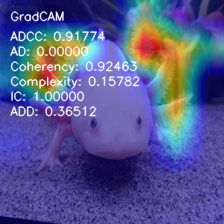

In [20]:
category = top5_indices[0][3] #  label is 0, but resnet18 think it is 2
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

torch.Size([1]) torch.Size([1, 1000])
tensor(-11.7295, device='cuda:0', grad_fn=<SubBackward0>)
torch.Size([1]) torch.Size([1, 1000])
tensor(-3.1559, device='cuda:0', grad_fn=<SubBackward0>)


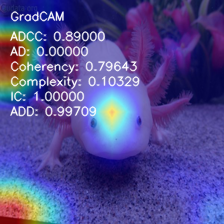

In [21]:
category = top5_indices[0][4] #  label is 0, but resnet18 think it is 2
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

torch.Size([1]) torch.Size([1, 1000])
tensor(-74.3941, device='cuda:0', grad_fn=<SubBackward0>)


torch.Size([1]) torch.Size([1, 1000])
tensor(-9.4317, device='cuda:0', grad_fn=<SubBackward0>)


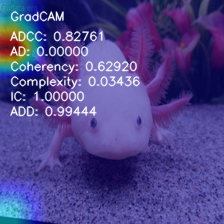

In [22]:
category = bottom5_indices[0][0] #  label is 0, but resnet18 think it is 2
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

torch.Size([1]) torch.Size([1, 1000])
tensor(-72.3650, device='cuda:0', grad_fn=<SubBackward0>)
torch.Size([1]) torch.Size([1, 1000])
tensor(-10.8211, device='cuda:0', grad_fn=<SubBackward0>)


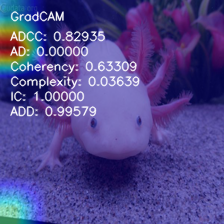

In [23]:
category = bottom5_indices[0][1] #  label is 0, but resnet18 think it is 2
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

torch.Size([1]) torch.Size([1, 1000])
tensor(-71.5694, device='cuda:0', grad_fn=<SubBackward0>)
torch.Size([1]) torch.Size([1, 1000])
tensor(-9.1508, device='cuda:0', grad_fn=<SubBackward0>)


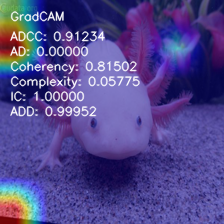

In [24]:
category =  bottom5_indices[0][2] #  label is 0, but resnet18 think it is 2
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

torch.Size([1]) torch.Size([1, 1000])
tensor(-71.0740, device='cuda:0', grad_fn=<SubBackward0>)
torch.Size([1]) torch.Size([1, 1000])
tensor(-8.6827, device='cuda:0', grad_fn=<SubBackward0>)


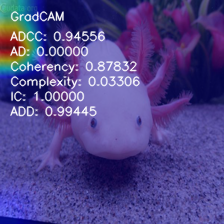

In [25]:
category =  bottom5_indices[0][3] #  label is 0, but resnet18 think it is 2
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

torch.Size([1]) torch.Size([1, 1000])
tensor(-70.3150, device='cuda:0', grad_fn=<SubBackward0>)
torch.Size([1]) torch.Size([1, 1000])
tensor(-11.7424, device='cuda:0', grad_fn=<SubBackward0>)


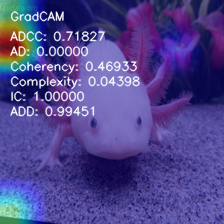

In [26]:
category =  bottom5_indices[0][4] #  label is 0, but resnet18 think it is 2
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)